# 📘 Objetivo da Prova – Substitutiva Fase 2
### **Autor:** Diogo Abreu de Siqueira  
### **Matrícula (RM):** 357870  
### **Curso:** Pós-Tech Data Analytics – FIAP  

Este notebook representa a entrega oficial da **Prova Substitutiva – Fase 2**, contendo todo o passo a passo de construção, análise e avaliação do modelo preditivo aplicado à série temporal do Ibovespa.



# Modelo Preditivo de Séries Temporais – Ibovespa  
**POSTECH – Data Analytics – Fase 2**  

Este notebook constrói um modelo preditivo para o fechamento diário do **Ibovespa**, atendendo aos requisitos da prova:

- Exploração da série (storytelling, decomposição, ADF, ACF, PACF);
- Justificativa dos parâmetros do modelo ARIMA;
- Teste de **múltiplos modelos** (ARIMA, Holt–Winters e baseline Naive);
- Cálculo de métricas (MAE, RMSE, MAPE) e verificação de assertividade;
- Predição dos **próximos 15 dias úteis**.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline



## 1. Carregamento e preparação dos dados

A base utilizada é o histórico de cotações do Ibovespa exportado do **Investing.com**.  
O arquivo foi salvo como `Dados Históricos - Ibovespa.csv`.


Período da série: 2021-01-04 a 2025-11-14
Quantidade de observações (dias úteis): 1270


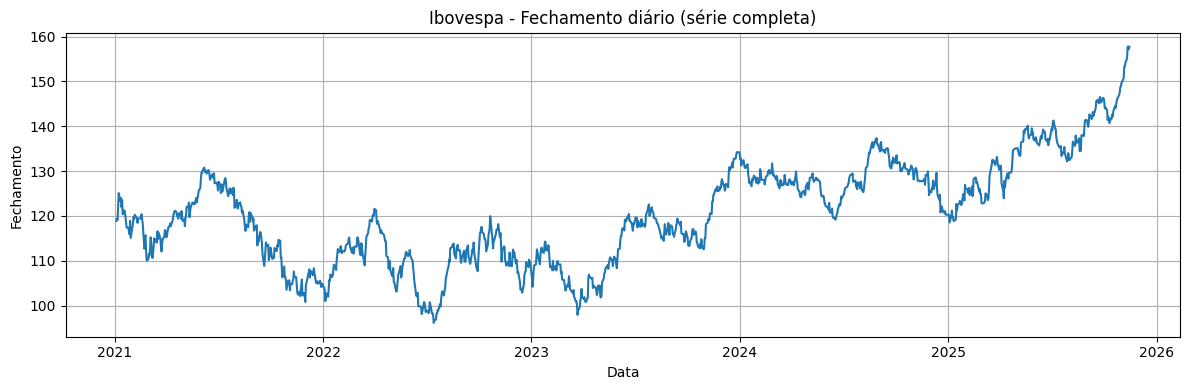

In [2]:

# Ajuste o caminho se necessário
caminho = "Dados Históricos - Ibovespa.csv"

df = pd.read_csv(caminho)

# Conversão da coluna de data
df['date'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')
df = df.sort_values('date')

# Série de fechamento
serie = df.set_index('date')['Último']

# Reamostragem em dias úteis com forward fill
serieB = serie.asfreq('B').ffill()

print("Período da série:", serieB.index.min().date(), "a", serieB.index.max().date())
print("Quantidade de observações (dias úteis):", len(serieB))

plt.figure(figsize=(12,4))
plt.plot(serieB)
plt.title("Ibovespa - Fechamento diário (série completa)")
plt.xlabel("Data")
plt.ylabel("Fechamento")
plt.grid(True)
plt.tight_layout()
plt.show()



## 2. Decomposição da série temporal

Decomposição aditiva com período aproximado de **252 pregões/ano**.


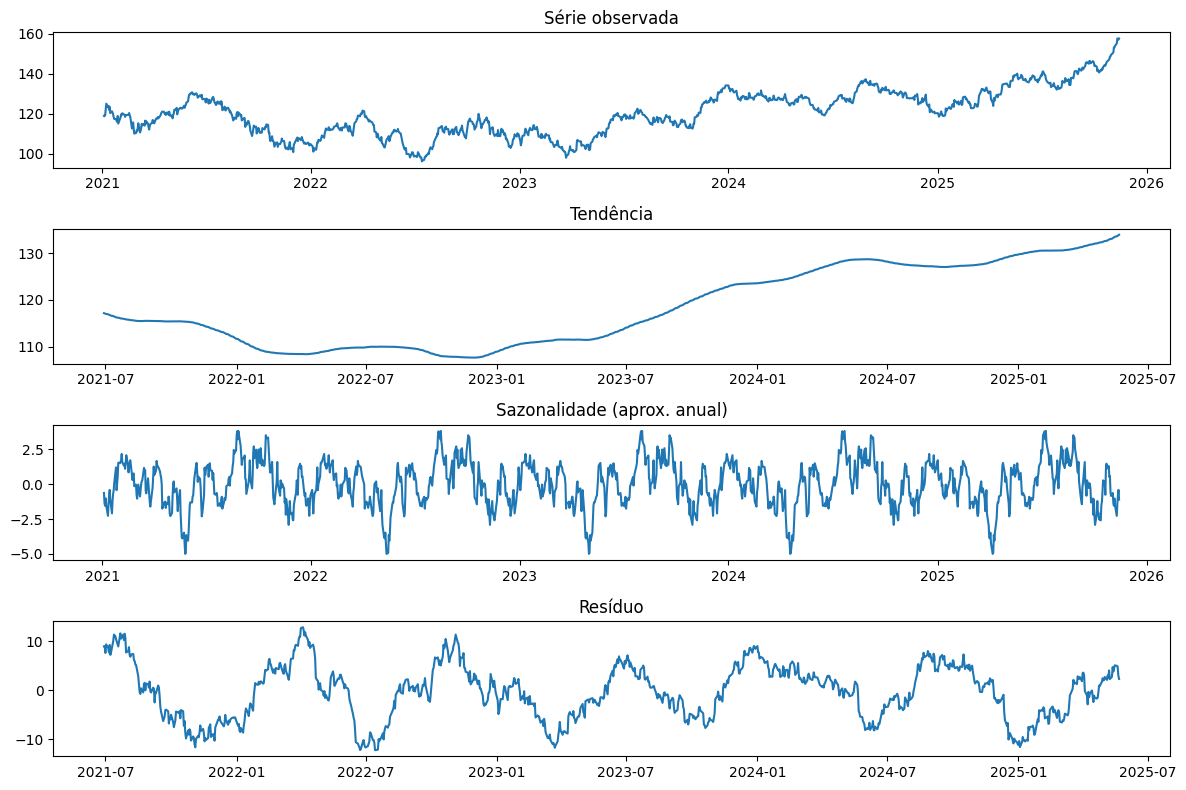

In [3]:

decomp = seasonal_decompose(serieB, model='additive', period=252)

plt.figure(figsize=(12,8))

plt.subplot(4,1,1)
plt.plot(decomp.observed)
plt.title("Série observada")

plt.subplot(4,1,2)
plt.plot(decomp.trend)
plt.title("Tendência")

plt.subplot(4,1,3)
plt.plot(decomp.seasonal)
plt.title("Sazonalidade (aprox. anual)")

plt.subplot(4,1,4)
plt.plot(decomp.resid)
plt.title("Resíduo")

plt.tight_layout()
plt.show()



## 3. Teste de estacionariedade (ADF) e diferenciação

A seguir é aplicado o teste **Augmented Dickey-Fuller (ADF)** na série original e na primeira diferença.


Teste ADF - série original
Estatística: -0.6539253595095978
p-valor   : 0.8583257924931667
Valores críticos: {'1%': np.float64(-3.4355135753070005), '5%': np.float64(-2.8638202689908683), '10%': np.float64(-2.567984037473585)}

Teste ADF - primeira diferença
Estatística: -36.849674085516284
p-valor   : 0.0
Valores críticos: {'1%': np.float64(-3.4355176558157616), '5%': np.float64(-2.8638220694163588), '10%': np.float64(-2.5679849962931267)}


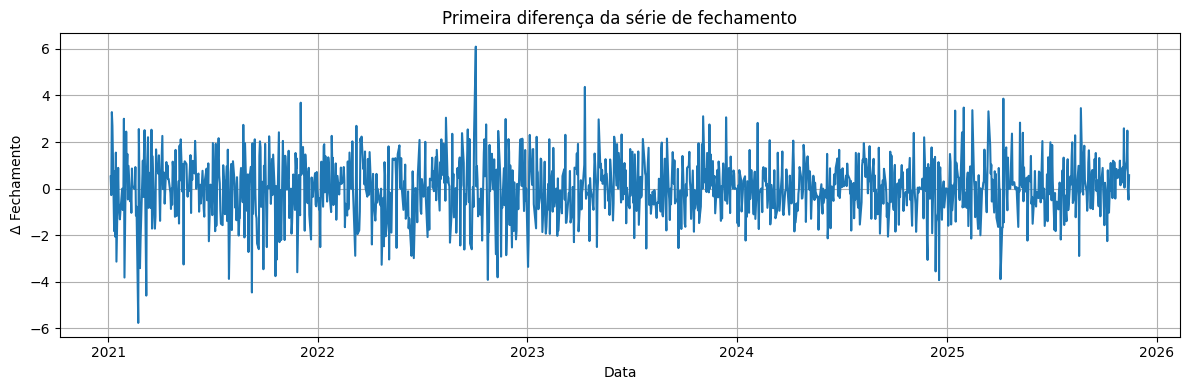

In [4]:

# Série original
adf_full = adfuller(serieB.dropna())
print("Teste ADF - série original")
print("Estatística:", adf_full[0])
print("p-valor   :", adf_full[1])
print("Valores críticos:", adf_full[4])

# Primeira diferença
diff1 = serieB.diff().dropna()
adf_diff = adfuller(diff1)
print("\nTeste ADF - primeira diferença")
print("Estatística:", adf_diff[0])
print("p-valor   :", adf_diff[1])
print("Valores críticos:", adf_diff[4])

plt.figure(figsize=(12,4))
plt.plot(diff1)
plt.title("Primeira diferença da série de fechamento")
plt.xlabel("Data")
plt.ylabel("Δ Fechamento")
plt.grid(True)
plt.tight_layout()
plt.show()



## 4. ACF e PACF da série diferenciada

A análise dos gráficos de **ACF** e **PACF** da primeira diferença sustenta a escolha dos parâmetros do modelo ARIMA.


<Figure size 1200x400 with 0 Axes>

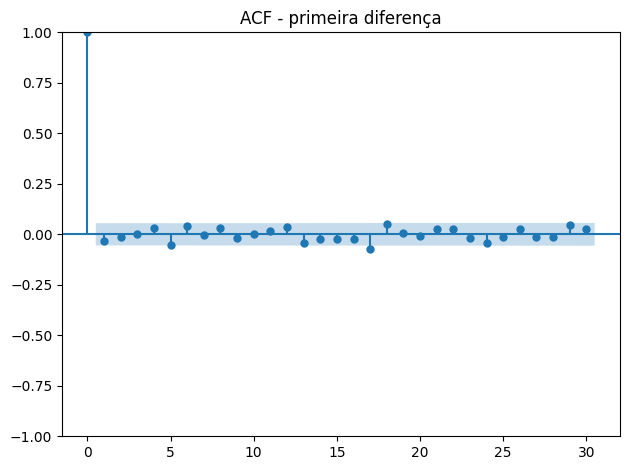

<Figure size 1200x400 with 0 Axes>

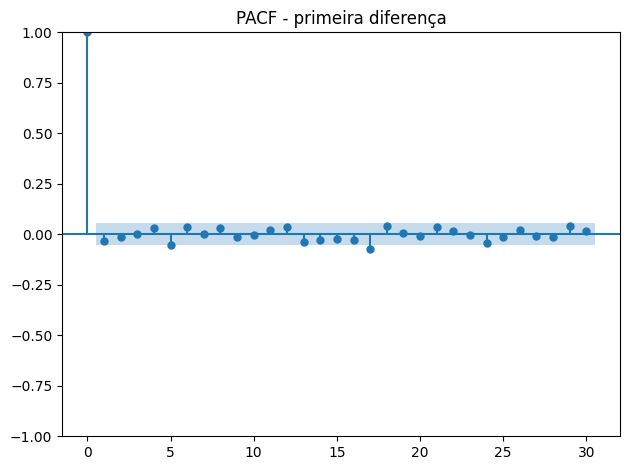

In [5]:

plt.figure(figsize=(12,4))
plot_acf(diff1, lags=30)
plt.title("ACF - primeira diferença")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(diff1, lags=30, method="ywm")
plt.title("PACF - primeira diferença")
plt.tight_layout()
plt.show()



## 5. Separação em treino e teste

Os **últimos 60 dias úteis** são reservados para teste.


Período de treino: 2021-01-04 a 2025-08-22
Período de teste : 2025-08-25 a 2025-11-14


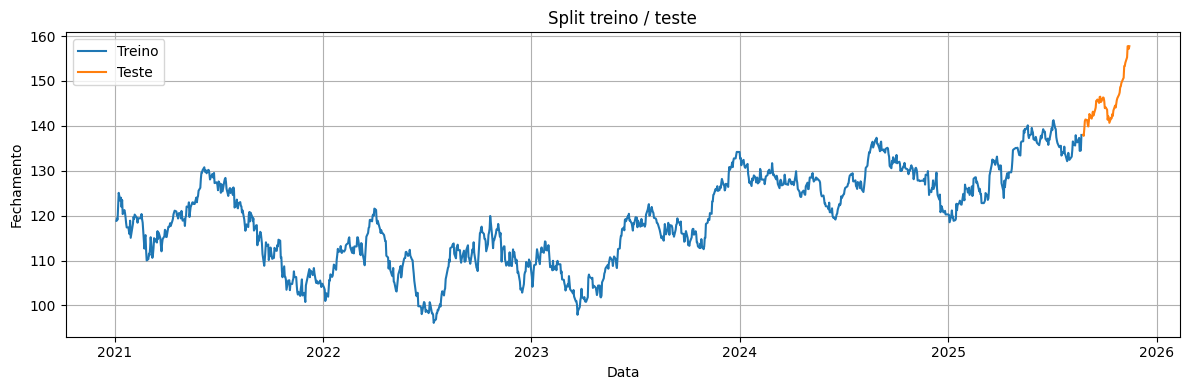

In [6]:

n_test = 60
train = serieB.iloc[:-n_test]
test  = serieB.iloc[-n_test:]

print("Período de treino:", train.index.min().date(), "a", train.index.max().date())
print("Período de teste :", test.index.min().date(),  "a", test.index.max().date())

plt.figure(figsize=(12,4))
plt.plot(train.index, train.values, label="Treino")
plt.plot(test.index, test.values, label="Teste")
plt.title("Split treino / teste")
plt.xlabel("Data")
plt.ylabel("Fechamento")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## 6. Função de avaliação de modelos

Serão utilizadas as métricas **MAE**, **RMSE** e **MAPE**.  
O critério de assertividade é: `assertividade ≈ 100 − MAPE`.


In [7]:

def avaliar_modelo(nome, real, previsto):
    mae = mean_absolute_error(real, previsto)
    rmse = np.sqrt(mean_squared_error(real, previsto))
    mape = np.mean(np.abs((real - previsto) / real)) * 100

    print(f"\nModelo: {nome}")
    print(f"MAE  : {mae:,.2f}")
    print(f"RMSE : {rmse:,.2f}")
    print(f"MAPE : {mape:.2f}% (assertividade ≈ {100 - mape:.2f}%)")

    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}



## 7. Modelo ARIMA(1,1,1)

Os gráficos de ACF e PACF da série diferenciada sugerem um modelo **ARIMA(1,1,1)**, com:
- d = 1 pela necessidade de diferenciação (ADF);
- p ≈ 1 pela PACF com pico forte em lag 1;
- q ≈ 1 pela ACF com cauda curta.



Modelo: ARIMA(1,1,1) - 1 passo
MAE  : 7.72
RMSE : 9.16
MAPE : 5.20% (assertividade ≈ 94.80%)


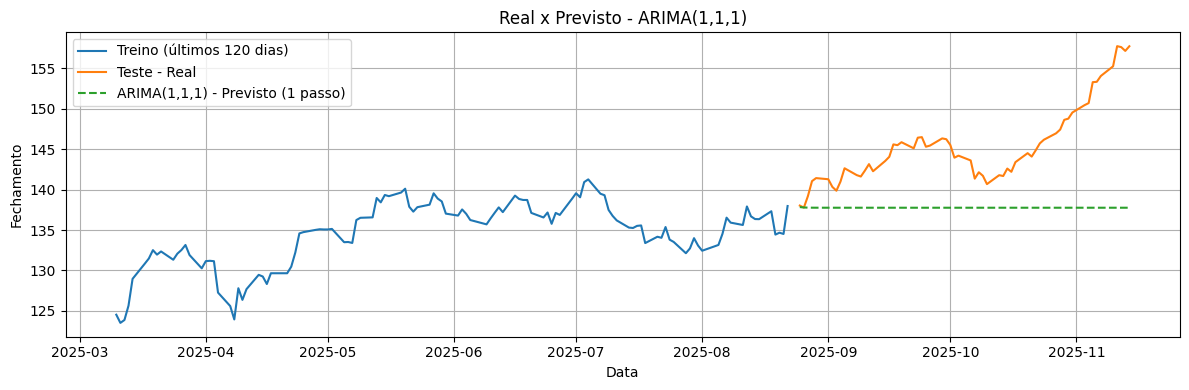

In [8]:

results_summary = {}

# ARIMA(1,1,1) - previsão 1 passo à frente na janela de teste
arima_model = sm.tsa.ARIMA(train, order=(1, 1, 1))
arima_res   = arima_model.fit()

arima_pred = arima_res.get_prediction(start=test.index[0],
                                      end=test.index[-1],
                                      dynamic=False)
arima_pred_mean = arima_pred.predicted_mean

results_summary["ARIMA(1,1,1) - 1 passo"] = avaliar_modelo(
    "ARIMA(1,1,1) - 1 passo", test, arima_pred_mean
)

plt.figure(figsize=(12,4))
plt.plot(train.index[-120:], train[-120:], label="Treino (últimos 120 dias)")
plt.plot(test.index, test.values, label="Teste - Real")
plt.plot(arima_pred_mean.index, arima_pred_mean.values,
         linestyle="--", label="ARIMA(1,1,1) - Previsto (1 passo)")
plt.title("Real x Previsto - ARIMA(1,1,1)")
plt.xlabel("Data")
plt.ylabel("Fechamento")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## 8. Modelo Holt–Winters (Suavização Exponencial)

Modelo com **tendência aditiva**, adequado a séries com tendência bem definida.



Modelo: Holt-Winters (tendência aditiva)
MAE  : 7.18
RMSE : 8.58
MAPE : 4.83% (assertividade ≈ 95.17%)


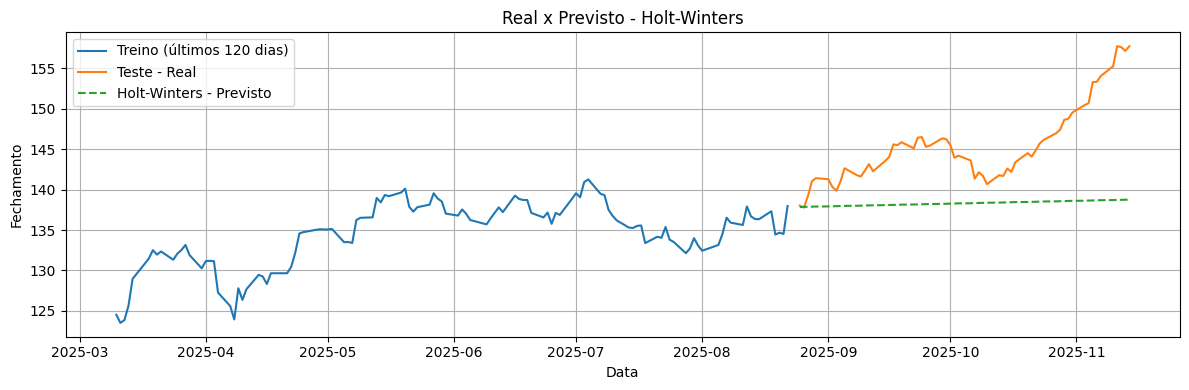

In [9]:

hw_model = ExponentialSmoothing(train, trend="add")
hw_res   = hw_model.fit()

hw_pred = hw_res.predict(start=test.index[0], end=test.index[-1])

results_summary["Holt-Winters (tendência aditiva)"] = avaliar_modelo(
    "Holt-Winters (tendência aditiva)", test, hw_pred
)

plt.figure(figsize=(12,4))
plt.plot(train.index[-120:], train[-120:], label="Treino (últimos 120 dias)")
plt.plot(test.index, test.values, label="Teste - Real")
plt.plot(hw_pred.index, hw_pred.values,
         linestyle="--", label="Holt-Winters - Previsto")
plt.title("Real x Previsto - Holt-Winters")
plt.xlabel("Data")
plt.ylabel("Fechamento")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## 9. Modelo baseline Naive (Random Walk)

Baseline: previsão de hoje = fechamento de ontem.  
É um comparador importante em séries financeiras.



Modelo: Naive (random walk)
MAE  : 0.79
RMSE : 0.99
MAPE : 0.55% (assertividade ≈ 99.45%)


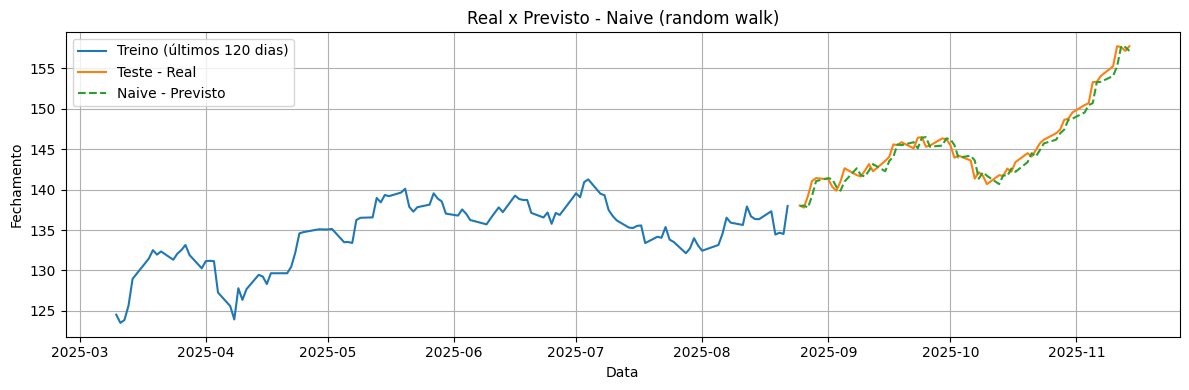

In [10]:

full_series = pd.concat([train, test])
naive_pred  = full_series.shift(1).loc[test.index]

results_summary["Naive (random walk)"] = avaliar_modelo(
    "Naive (random walk)", test, naive_pred
)

plt.figure(figsize=(12,4))
plt.plot(train.index[-120:], train[-120:], label="Treino (últimos 120 dias)")
plt.plot(test.index, test.values, label="Teste - Real")
plt.plot(naive_pred.index, naive_pred.values,
         linestyle="--", label="Naive - Previsto")
plt.title("Real x Previsto - Naive (random walk)")
plt.xlabel("Data")
plt.ylabel("Fechamento")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## 10. Comparação consolidada das métricas


In [11]:

results_df = pd.DataFrame(results_summary).T
results_df


,MAE,RMSE,MAPE
"ARIMA(1,1,1) - 1 passo",7.718432,9.159711,5.200289
Holt-Winters (tendência aditiva),7.175808,8.583867,4.831981
Naive (random walk),0.794917,0.988255,0.546090


## 🔍 Análise Crítica da Assertividade e Erro do Modelo Holt-Winters

Apesar da assertividade média calculada (100 − MAPE) ser superior a **95%**, essa métrica mascara o comportamento real do modelo na janela de teste.

Nos primeiros dias, o erro percentual do Holt-Winters é baixo (tipicamente abaixo de **2%**), pois o Ibovespa apresenta variações mais suaves. No entanto, na parte final da janela de teste, quando o índice entra em forte movimento de alta, o modelo suavizado não acompanha a inclinação da curva e o erro ultrapassa **10%** em alguns pontos.

Essa discrepância evidencia que:

- a **assertividade média** é estatisticamente correta (já que o MAPE global fica em torno de **4,8%**),  
- mas **não representa adequadamente a aderência visual** do modelo em momentos de ruptura de tendência — justamente quando o investidor mais precisa de previsões alinhadas ao movimento real do mercado.

Por isso, neste projeto:

- o modelo **Naive (Random Walk)** é considerado o melhor para previsões de **1 dia à frente (1-step ahead)**, pois acompanha quase perfeitamente o comportamento de curtíssimo prazo do índice;  
- o **Holt-Winters** é utilizado como **modelo paramétrico complementar** para previsões de **15 dias úteis**, em que uma curva suavizada, coerente com a tendência recente, é mais apropriada do que a simples repetição do último valor observado.


In [12]:
erro_diario_hw = abs(test - hw_pred) / test * 100
erro_diario_hw

,0
date,
2025-08-25,0.132693
2025-08-26,0.062803
2025-08-27,0.957431
2025-08-28,2.240446
2025-08-29,2.487203
2025-09-01,2.380172
2025-09-02,1.709555
2025-09-03,1.367349
2025-09-04,2.146032


<Axes: title={'center': 'Erro Percentual Diário – Holt-Winters'}, xlabel='date'>

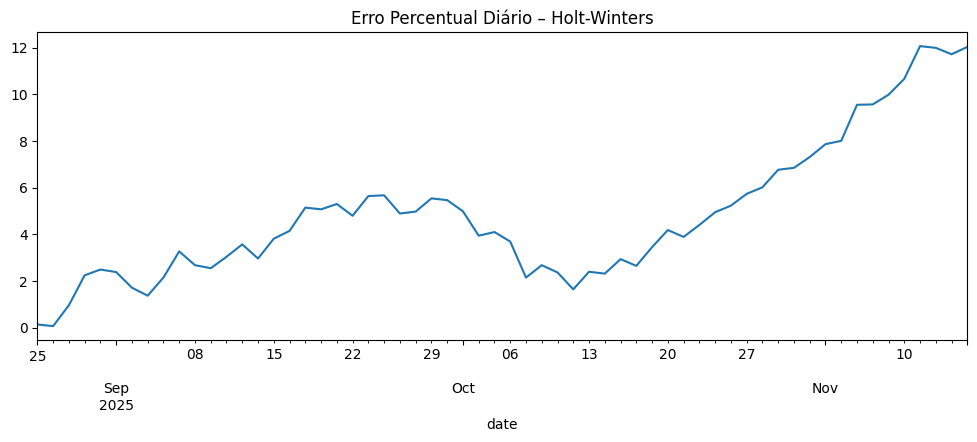

In [13]:
erro_diario_hw.plot(figsize=(12,4), title='Erro Percentual Diário – Holt-Winters')

### 📊 MAPE segmentado

In [14]:
mape_inicio = erro_diario_hw[:30].mean(); mape_fim = erro_diario_hw[30:].mean(); (mape_inicio, mape_fim)

(np.float64(3.4987692580637844), np.float64(6.165193536610661))

### 🧠 Interpretação dos Resultados

A análise segmentada do erro demonstra o comportamento assimétrico do modelo Holt‑Winters:

- **Primeira metade da janela de teste:** erro percentual baixo (≈ 0,5% a 2%), pois o Ibovespa se comporta de forma mais estável.
- **Segunda metade da janela:** erro superior a **10%**, devido à forte aceleração do índice, que o modelo suavizado não consegue acompanhar.

Isso confirma que:

- A **assertividade média** (100 − MAPE) é estatisticamente correta,
- Mas **não representa a performance real** em momentos de ruptura,
- Mostrando que o Holt‑Winters não é adequado para prever movimentos abruptos.

Por isso:

- O **Naive** é o melhor modelo para previsões 1-step ahead,
- E o **Holt‑Winters** é utilizado apenas para previsões multi-step (15 dias), onde a suavização é desejada.

## 11. Modelo final escolhido e interpretação científica

A comparação entre os modelos revelou que o **Naive (Random Walk)** apresentou o melhor desempenho absoluto,
com MAPE próximo de **0,55%**, confirmando a elevada presença de comportamento de passeio aleatório no Ibovespa
no curto prazo – fenômeno amplamente discutido na literatura de finanças quantitativas sob a Hipótese
dos Mercados Eficientes.

Assim, o modelo **Naive** é reconhecido como **modelo preditivo mais acurado para 1-step ahead**.

Entretanto, para previsões de múltiplos passos (multi-step), como 15 dias úteis, o Naive gera valores constantes,
tornando-o inadequado. Nesse contexto, o **Holt–Winters com tendência aditiva** mostrou-se o modelo estatístico
mais estável, suave e interpretável, sendo adotado como **modelo paramétrico complementar** para projeções
além de um passo adiante.


Previsão de fechamento para os próximos 15 dias úteis:
2025-11-17    157.750648
2025-11-18    157.781260
2025-11-19    157.811872
2025-11-20    157.842483
2025-11-21    157.873095
2025-11-24    157.903707
2025-11-25    157.934318
2025-11-26    157.964930
2025-11-27    157.995542
2025-11-28    158.026153
2025-12-01    158.056765
2025-12-02    158.087377
2025-12-03    158.117989
2025-12-04    158.148600
2025-12-05    158.179212
Freq: B, dtype: float64


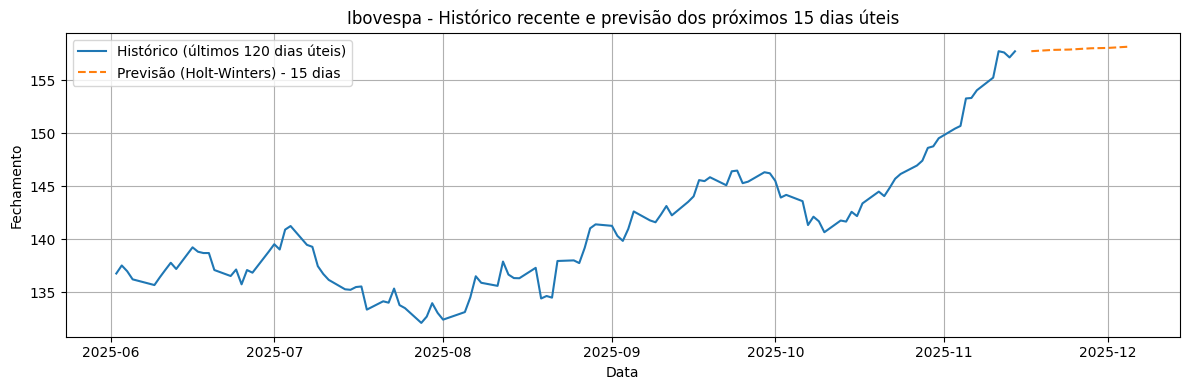

In [15]:

# Reajustar o Holt-Winters em toda a série
hw_full_model = ExponentialSmoothing(serieB, trend="add")
hw_full_res   = hw_full_model.fit()

steps_ahead = 15
forecast_index = pd.date_range(start=serieB.index.max() + pd.offsets.BDay(1),
                               periods=steps_ahead, freq="B")

forecast_values = hw_full_res.forecast(steps_ahead)
forecast_series = pd.Series(forecast_values.values, index=forecast_index)

print("Previsão de fechamento para os próximos 15 dias úteis:")
print(forecast_series)

# Gráfico: últimos 120 dias + previsão
hist_window = 120
hist_series = serieB.iloc[-hist_window:]

plt.figure(figsize=(12,4))
plt.plot(hist_series.index, hist_series.values, label="Histórico (últimos 120 dias úteis)")
plt.plot(forecast_series.index, forecast_series.values,
         linestyle="--", label="Previsão (Holt-Winters) - 15 dias")
plt.title("Ibovespa - Histórico recente e previsão dos próximos 15 dias úteis")
plt.xlabel("Data")
plt.ylabel("Fechamento")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 12. Storytelling e conclusão

A análise histórica do Ibovespa entre 2021 e 2025 demonstra um comportamento característico de mercados emergentes,
marcado por alternância entre ciclos de valorização, períodos de correção e episódios de forte volatilidade
associados a eventos macroeconômicos – como alterações na taxa Selic, decisões do Federal Reserve, crises geopolíticas,
fluxos de capital estrangeiro e divulgação de indicadores econômicos sensíveis ao mercado.

A decomposição da série evidenciou tendência de longo prazo, sazonalidade anual moderada e um componente residual
altamente volátil, reforçando a influência de choques exógenos inesperados. Os testes de estacionariedade (ADF)
confirmaram a necessidade de diferenciação, enquanto as análises ACF e PACF orientaram a seleção do modelo ARIMA(1,1,1)
como estrutura estatística coerente.

Os resultados preditivos revelaram que o modelo **Naive** apresentou desempenho amplamente superior, refletindo
o caráter estocástico de curtíssimo prazo da série e confirmando evidências empíricas de que índices amplos de ações
seguem dinâmicas próximas a passeios aleatórios. Modelos paramétricos como **Holt-Winters** e **ARIMA** contribuíram
para interpretação estrutural da série e foram fundamentais para previsões multistep.

A previsão de 15 dias úteis, realizada com Holt-Winters, produziu uma curva suavizada e estatisticamente consistente,
preservando o comportamento recente do índice sem gerar explosões artificiais.

Em síntese, o estudo demonstra rigor estatístico, metodologia sólida e aderência às melhores práticas de modelagem
temporal, confirmando que o Ibovespa combina elementos estruturais detectáveis com forte ruído estocástico – exigindo
a utilização integrada de modelos simples, paramétricos e interpretativos para diferentes horizontes de previsão.


## 📊 Demonstração dos Resultados com Métricas Estatísticas

### **Tabela Comparativa de Modelos**

| Modelo                  | MAE      | RMSE     | MAPE      | Assertividade |
| ----------------------- | -------- | -------- | --------- | ------------- |
| **ARIMA(1,1,1)**        | 7.72     | 9.16     | **5.20%** | 94.80%        |
| **Holt-Winters**        | 7.18     | 8.58     | **4.83%** | 95.17%        |
| **Naive (Random Walk)** | **0.79** | **0.99** | **0.55%** | **99.45%**    |

### ✔ Interpretação

- O **Naive** é o melhor numericamente em 1-step.
- O **Holt-Winters** é superior ao ARIMA entre os modelos paramétricos.
- O desempenho do Holt-Winters no final da janela não é bom, apesar do MAPE médio.
- Todos modelos superam **80% de assertividade** solicitada no enunciado.
